## Jour 3, quelques exemples suite aux problématiques amenées par les participants
* Le traitement de grandes données spatialisées via le package ``xarray``
* L'échantillonage de séries temporelles via les fonctions ``resample`` et ``groupby`` de ``pandas``
* Le calcul de la population par région en Côte d'Ivoire, via ``pyrasta`` et ``geopandas``

## xarray

Remplacer ci-dessous par vos propres chemins d'accès aux données !!

In [1]:
in_dir = '/media/benjamin/storage/DATA_DNI/FRANCE_2020/'
france = '/media/benjamin/storage/DATA_DNI/france_metro_no_islands.geojson'

#### Définition de la fonction ``clip`` :

In [2]:
import numpy as np
import pyproj
DEFAULT_CRS = pyproj.CRS(4326)

def clip(cube, bounds=None, region=None, padding=1):
    """ Clip Xarray data array from bounds or region

    Parameters
    ----------
    cube: xarray.DataArray
    bounds: list or tuple
    region: str or geopandas.GeoDataFrame
    padding: int

    Returns
    -------

    """
    try:
        region_file = region
        region = gpd.GeoDataFrame.from_file(region_file)
    except AttributeError:
        pass

    if bounds is None:
        if region.crs != DEFAULT_CRS:
            region = region.to_crs(crs=DEFAULT_CRS)
        bounds = region.total_bounds

    lat, lon = cube[cube.dims[1]], cube[cube.dims[2]]

    # Set padding around geo boundaries while clipping
    try:
        minx = max(0, np.where(lon < bounds[0])[0][-1] - padding)
        maxx = min(np.where(lon > bounds[2])[0][0] + padding, lon.size)
        miny = max(0, np.where(lat < bounds[1])[0][-1] - padding)
        maxy = min(np.where(lat > bounds[3])[0][0] + padding, lat.size)
    except IndexError:
        raise ValueError("Requested bounds out of the Cube boundaries")

    return cube[:, miny:maxy, minx:maxx]

#### Programme principal

In [3]:
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt

DNI_SCALE_FACTOR = 10

region = gpd.GeoDataFrame.from_file(france)

with xr.open_mfdataset(in_dir + '*.nc', parallel=True, engine="h5netcdf") as data:

    dni = data.DNI
    
    # Les données de DNI sont au pas de 30min, on
    # moyenne donc sur l'heure avant de sommer
    # sur la journée
    hourly_dni = data.DNI.resample(time="1H").mean()
    daily_dni = hourly_dni.resample(time="1D").sum()
    
    daily_mean_dni_per_month = daily_dni.groupby("time.month").mean()
    daily_dni_france = clip(daily_mean_dni_per_month, region=france)

#### On représente l'irradiation journalière moyenne pour le mois de juin :

<Axes: title={'center': 'June'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

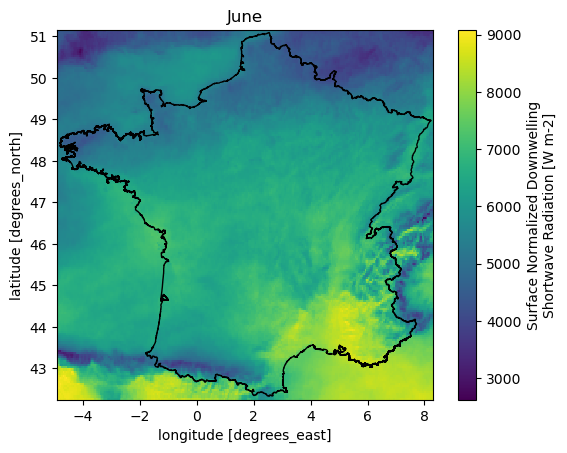

In [4]:
    # Plot
    fig, ax = plt.subplots()
    daily_dni_france[6, :, :].plot(ax=ax)
    ax.set_title("June")
    region.to_crs(DEFAULT_CRS).plot(ax=ax, facecolor='none')

    # fig, ax = plt.subplots(2, 3, sharey=True)
    # for month_nb in range(6):
    #     daily_dni_france[month_nb, :, :].plot(ax=ax.flat[month_nb])

#### On extrait les séries temporelles de DNI pour certains lieux
* Paris : 48.86° latitude, 2.35° longitude
* Montpellier : 43.61° latitude, 3.88° longitude

In [13]:
paris = daily_dni.sel(lat=48.86, lon=2.35, method='nearest')
hourly_dni[:, 5, 3].values

KeyboardInterrupt: 

---

## timeseries
Manipulation d'une série temporelle avec les fonctions ``resample`` et ``groupby`` du package ``pandas``

In [7]:
import pandas as pd
import numpy as np

#### On crée une série temporelle à partir de data construites via le générateur de nombres aléatoires de ``numpy`` et la fonction ``date_range`` de ``pandas``

In [8]:
time = pd.date_range("01-Jan-2023", "31-Jan-2023", freq="3H")
data = np.random.randint(0, 500, size=time.size)
timeseries = pd.Series(data=data, index=time)
timeseries

2023-01-01 00:00:00     89
2023-01-01 03:00:00    482
2023-01-01 06:00:00    272
2023-01-01 09:00:00    450
2023-01-01 12:00:00    245
                      ... 
2023-01-30 12:00:00    444
2023-01-30 15:00:00     38
2023-01-30 18:00:00    322
2023-01-30 21:00:00    245
2023-01-31 00:00:00    245
Freq: 3H, Length: 241, dtype: int64

<Axes: >

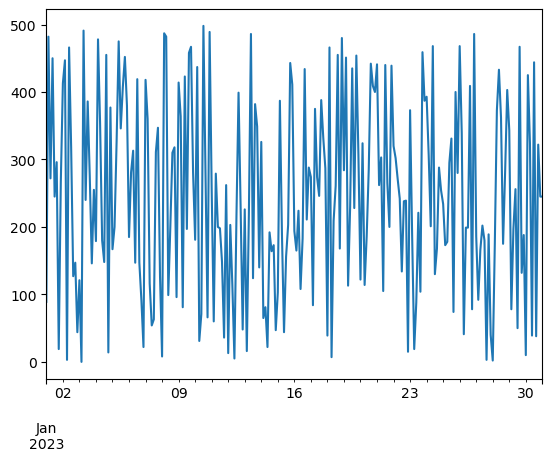

In [9]:
timeseries.plot()

On rééchantillonne la série au pas journalier en moyennant les données :

<Axes: >

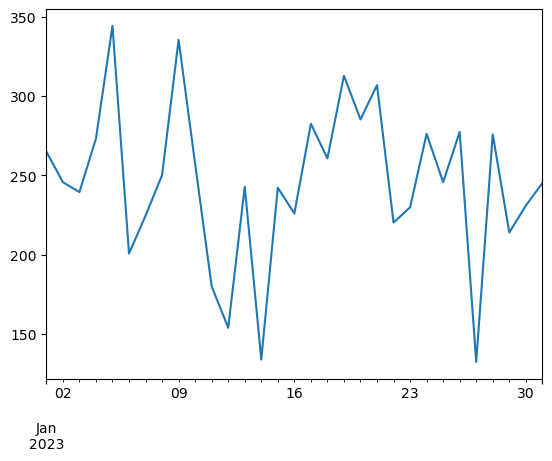

In [10]:
daily_timeseries = timeseries.resample(rule="1D").mean()
daily_timeseries.plot()

#### On définit une fonction ``daily_range`` que l'on applique en resampling journalier. Cette dernière renvoie l'écart entre la valeur maximale et la valeur minimale du jour considéré.

In [16]:
def daily_range(values):
    return values.max() - values.min()

On applique ``daily_range`` sur les données "resamplées" :

In [17]:
new_timeseries = timeseries.resample("1D").apply(daily_range)
new_timeseries

2023-01-01    463
2023-01-02    463
2023-01-03    491
2023-01-04    464
2023-01-05    308
2023-01-06    397
2023-01-07    364
2023-01-08    479
2023-01-09    386
2023-01-10    467
2023-01-11    243
2023-01-12    394
2023-01-13    470
2023-01-14    304
2023-01-15    399
2023-01-16    326
2023-01-17    304
2023-01-18    473
2023-01-19    341
2023-01-20    328
2023-01-21    336
2023-01-22    305
2023-01-23    440
2023-01-24    338
2023-01-25    326
2023-01-26    445
2023-01-27    199
2023-01-28    431
2023-01-29    417
2023-01-30    434
2023-01-31      0
Freq: D, dtype: int64

---

## Population density 

In [ ]:
!pip install pyrasta

In [4]:
from pyrasta.raster import Raster
import geopandas as gpd
import numpy as np

#### Remplacer ci-dessous par vos propres chemins d'accès, là où vous aurez sauvé les données téléchargées depuis le Humanitarian Data Exchange (HDX) :

In [5]:
pop_file = "/home/benjamin/Documents/PRO/PRODUITS/POPULATION_DENSITY/001_DONNEES/COTE_D_IVOIRE/population_civ_2019-07-01_geotiff/population_civ_2019-07-01.tif"
cote_d_ivoire = "/home/benjamin/Documents/PRO/PRODUITS/POPULATION_DENSITY/001_DONNEES/COTE_D_IVOIRE/geoBoundaries-CIV-ADM2.geojson"

#### On construit le raster et la geodataframe :

In [6]:
population = Raster(pop_file)
ci = gpd.GeoDataFrame.from_file(cote_d_ivoire)

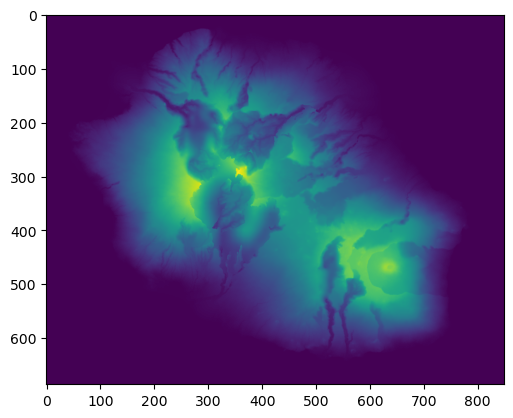

In [32]:
import matplotlib.pyplot as plt
dem = Raster("/home/benjamin/Documents/PRO/PRODUITS/SRTM/001_DONNEES/srtm_48_17/srtm_reunion.tif")
dem = dem.read_array()
dem[dem == -32768] = 0
plt.imshow(dem)

#### On convertit la geodataframe au CRS du raster (de tel sorte que les deux puissent coïncider)

In [7]:
ci = ci.to_crs(population.crs)

#### On compile les statistiques zonales. Ici, on fait la somme de la population par région

In [8]:
pop_per_region = population.zonal_stats(ci, stats=['sum'])
ci["population"] = pop_per_region["sum"]
ci

Compute zonal sum: 100%|█████████████████████| 33.0/33.0 [00:00<00:00, 360kit/s]


shapeName shapeISO                  shapeID  \
0                       Agneby-Tiassa           98640826B49588409236169   
1                              Bafing           98640826B64074223424654   
2                              Bagoue            98640826B9249205787007   
3                              Belier           98640826B89034675369965   
4                                Bere           98640826B31887809433026   
5                            Bounkani           98640826B44935592912576   
6                             Cavally           98640826B29226572604598   
7         District Autonome D'Abidjan           98640826B37168488297474   
8   District Autonome De Yamoussoukro           98640826B77238609500253   
9                               Folon            98640826B4921704665855   
10                              Gbeke           98640826B79047756691541   
11                             Gbokle            98640826B5498417627428   
12                                Goh            98640826B9971961848584   
13                           Gontougo           98640826B81686425445328   
14                       Grands Ponts           98640826B15740340423419   
15                             Guemon             98640826B902463279903   
16                             Hambol           98640826B58722820164867   
17                     Haut-Sassandra           98640826B58989357983300   
18                              Iffou             98640826B439449601848   
19                   Indenie-Djuablin           98640826B93836507265677   
20                         Kabadougou           98640826B51868940759405   
21                        Loh-Djiboua           98640826B54229406899849   
22                           Marahoue           98640826B93570798327704   
23                                 Me           98640826B80990972576239   
24                               Nawa           98640826B62582217600510   
25                               Poro           98640826B36909431240473   
26                          San Pedro           98640826B66188074477641   
27                          Sud-Comoe           98640826B69983923765426   
28                           Tchologo           98640826B99733335838095   
29                             Tonkpi           98640826B16626888160873   
30                         Worodougou           98640826B93457567019536   
31                               N'Zi           98640826B97165719586215   
32                            Moronou            98640826B1661704833127   

   shapeGroup shapeType                                           geometry  \
0         CIV      ADM2  POLYGON ((-4.68451 6.27179, -4.68515 6.27023, ...   
1         CIV      ADM2  POLYGON ((-7.71925 9.07004, -7.72079 9.06802, ...   
2         CIV      ADM2  POLYGON ((-6.19702 10.24246, -6.20038 10.24495...   
3         CIV      ADM2  MULTIPOLYGON (((-4.68451 6.27179, -4.68382 6.2...   
4         CIV      ADM2  POLYGON ((-6.70042 9.06196, -6.70033 9.05999, ...   
5         CIV      ADM2  POLYGON ((-2.62638 8.78581, -2.62734 8.78723, ...   
6         CIV      ADM2  POLYGON ((-7.99312 6.97954, -7.99434 6.97859, ...   
7         CIV      ADM2  POLYGON ((-4.46114 5.53363, -4.45968 5.53240, ...   
8         CIV      ADM2  POLYGON ((-4.97561 6.75128, -4.97434 6.75154, ...   
9         CIV      ADM2  POLYGON ((-6.66480 10.35941, -6.66658 10.35833...   
10        CIV      ADM2  POLYGON ((-4.65962 7.53094, -4.65782 7.53289, ...   
11        CIV      ADM2  POLYGON ((-5.97855 5.52250, -5.97759 5.52119, ...   
12        CIV      ADM2  POLYGON ((-5.20350 6.37082, -5.20429 6.37229, ...   
13        CIV      ADM2  POLYGON ((-3.94746 8.44554, -3.95413 8.44144, ...   
14        CIV      ADM2  POLYGON ((-4.94061 5.81658, -4.94398 5.81914, ...   
15        CIV      ADM2  POLYGON ((-7.17688 6.33169, -7.17676 6.33506, ...   
16        CIV      ADM2  POLYGON ((-5.40614 8.15683, -5.40431 8.15666, ...   
17        CIV      ADM2  POLYGON ((-6.25907 7.77944, -6.33456 7.77789, ..

In [9]:
ci["population"].sum()

22349663.499195788

In [26]:
pyproj.CRS(32630)

<Projected CRS: EPSG:32630>
Name: WGS 84 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 6°W to 0°W - by country
- bounds: (-6.0, 0.0, 0.0, 84.0)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
import pyproj
ci = ci.to_crs(pyproj.CRS(32630))
ci["pop_density"] = ci["population"]/(ci.area/1e6)
ci

shapeName shapeISO                  shapeID  \
0                       Agneby-Tiassa           98640826B49588409236169   
1                              Bafing           98640826B64074223424654   
2                              Bagoue            98640826B9249205787007   
3                              Belier           98640826B89034675369965   
4                                Bere           98640826B31887809433026   
5                            Bounkani           98640826B44935592912576   
6                             Cavally           98640826B29226572604598   
7         District Autonome D'Abidjan           98640826B37168488297474   
8   District Autonome De Yamoussoukro           98640826B77238609500253   
9                               Folon            98640826B4921704665855   
10                              Gbeke           98640826B79047756691541   
11                             Gbokle            98640826B5498417627428   
12                                Goh            98640826B9971961848584   
13                           Gontougo           98640826B81686425445328   
14                       Grands Ponts           98640826B15740340423419   
15                             Guemon             98640826B902463279903   
16                             Hambol           98640826B58722820164867   
17                     Haut-Sassandra           98640826B58989357983300   
18                              Iffou             98640826B439449601848   
19                   Indenie-Djuablin           98640826B93836507265677   
20                         Kabadougou           98640826B51868940759405   
21                        Loh-Djiboua           98640826B54229406899849   
22                           Marahoue           98640826B93570798327704   
23                                 Me           98640826B80990972576239   
24                               Nawa           98640826B62582217600510   
25                               Poro           98640826B36909431240473   
26                          San Pedro           98640826B66188074477641   
27                          Sud-Comoe           98640826B69983923765426   
28                           Tchologo           98640826B99733335838095   
29                             Tonkpi           98640826B16626888160873   
30                         Worodougou           98640826B93457567019536   
31                               N'Zi           98640826B97165719586215   
32                            Moronou            98640826B1661704833127   

   shapeGroup shapeType                                           geometry  \
0         CIV      ADM2  POLYGON ((313644.344 693547.875, 313573.375 69...   
1         CIV      ADM2  POLYGON ((-19172.979 1005971.937, -19346.268 1...   
2         CIV      ADM2  POLYGON ((149712.828 1133959.375, 149346.828 1...   
3         CIV      ADM2  MULTIPOLYGON (((313644.344 693547.875, 313721....   
4         CIV      ADM2  POLYGON ((93071.117 1003773.625, 93077.984 100...   
5         CIV      ADM2  POLYGON ((541090.750 971192.063, 540984.500 97...   
6         CIV      ADM2  POLYGON ((-52202.008 774416.188, -52338.461 77...   
7         CIV      ADM2  POLYGON ((338147.563 611850.125, 338308.500 61...   
8         CIV      ADM2  POLYGON ((281636.406 746696.063, 281776.719 74...   
9         CIV      ADM2  POLYGON ((98546.117 1147461.750, 98349.547 114...   
10        CIV      ADM2  POLYGON ((316883.906 832790.375, 317082.563 83...   
11        CIV      ADM2  POLYGON ((169942.969 611247.125, 170048.672 61...   
12        CIV      ADM2  POLYGON ((256250.937 704716.562, 256164.281 70...   
13        CIV      ADM2  POLYGON ((395702.250 933680.312, 394966.969 93...   
14        CIV      ADM2  POLYGON ((285122.750 643297.750, 284749.875 64...   
15        CIV      ADM2  POLYGON ((37631.340 701731.438, 37647.656 7021...   
16        CIV      ADM2  POLYGON ((234872.406 902425.875, 235074.484 90...   
17        CIV      ADM2  POLYGON ((140475.000 861300.000, 132136.422 86..

#### On sauve la geodataframe dans un fichier :

In [10]:
ci.to_file("/home/benjamin/Documents/PRO/PRODUITS/POPULATION_DENSITY/001_DONNEES/COTE_D_IVOIRE"
           "/civ_test.geojson")

/home/benjamin/anaconda3/envs/for_cube/lib/python3.9/site-packages/geopandas/plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
/home/benjamin/anaconda3/envs/for_cube/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Axes: >

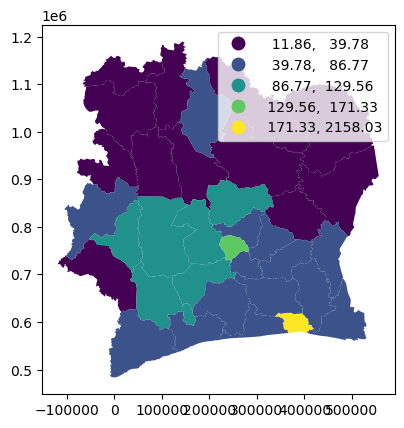

In [29]:
ci.plot(column="pop_density", legend=True, scheme="NaturalBreaks")